In [1]:
from glob import glob
import json
from datetime import datetime as dt, timedelta as td
import pandas as pd
pd.options.display.max_rows = 500
from time import sleep
from matplotlib.patches import Patch
import seaborn as sns

In [2]:
sns.set_theme(style="white", palette="bright")

Italy covid epidemic data: https://github.com/pcm-dpc/COVID-19

Italy covid vaccination data: https://github.com/italia/covid19-opendata-vaccini

UK covid data:
https://coronavirus.data.gov.uk/details/download

## UK Data

In [3]:
UK_population = 67220
UK_population_over50 = 25491  # From https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationprojections/datasets/tablea21principalprojectionukpopulationinagegroups
UK_population_under12 = 3782 + 4147 + (4045 * 2 / 5)  # From https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates
# Since population in the referenced sheet is grouped in 5-year blocks, I am counting 2/5 of the 10-14 block
UK_population_over12 = UK_population - UK_population_under12

England_population = 56286
Wales_population = 3136
Scotland_population = 5454

In [4]:
UK_death_total = 174
UK_cases_total = 22000

# Total ICU beds
# IMPORTANT: I could not find explicit data on number of beds available to accommodate acute COVID-19 patients.
# According to the few sources below, I'm setting this number to 6000
# https://www.kingsfund.org.uk/projects/nhs-in-a-nutshell/hospital-beds
# https://www.england.nhs.uk/statistics/statistical-work-areas/critical-care-capacity/
# https://www.bma.org.uk/advice-and-support/nhs-delivery-and-workforce/pressures/nhs-hospital-beds-data-analysis
UK_ICU_beds = 6000

In [5]:
_UK_api_url = 'https://api.coronavirus.data.gov.uk/v2/data'
_UK_api_params = {
    'areaType': 'overview',
    'format': 'csv'
}

_UK_api_metric_names = pd.read_json('UK_data/metrics_null.json')

In [6]:
%%time
failed = []
UK_data = pd.DataFrame()
for i in range(len(_UK_api_metric_names) // 5):
    _metrics = _UK_api_metric_names['metric'][i*5:(i+1)*5].to_list()
    print(f'{i} Selecting {" ".join(_metrics)}')
    _params = list(_UK_api_params.items()) + [('metric', m) for m in _metrics]
    _url = _UK_api_url + '?' + "&".join(f'{k}={v}' for k, v in _params)
    try:
        _temp = pd.read_csv(_url)
        if _temp.empty:
            print('Empty dataset')
            continue
        _temp['date'] = pd.to_datetime(_temp['date'])
        if UK_data.empty:
            UK_data = _temp
        else:
            UK_data = UK_data.merge(_temp[['date'] + _metrics], on='date', how='outer')
    except Exception as e:
        print(e)
        print(_metrics)
        failed.extend(_metrics)
    sleep(1.5)

0 Selecting alertLevel capacityPillarFour capacityPillarOne capacityPillarOneTwo capacityPillarThree
1 Selecting capacityPillarTwo changeInNewCasesBySpecimenDate covidOccupiedMVBeds cumAdmissions cumAdmissionsByAge
HTTP Error 500: Internal Server Error
['capacityPillarTwo', 'changeInNewCasesBySpecimenDate', 'covidOccupiedMVBeds', 'cumAdmissions', 'cumAdmissionsByAge']
2 Selecting cumAntibodyTestsByPublishDate cumCasesByPublishDate cumCasesByPublishDateRate cumCasesBySpecimenDate cumCasesBySpecimenDateRate
3 Selecting cumCasesLFDConfirmedPCRBySpecimenDate cumCasesLFDOnlyBySpecimenDate cumCasesPCROnlyBySpecimenDate cumDailyNsoDeathsByDeathDate cumDeaths28DaysByDeathDate
4 Selecting cumDeaths28DaysByDeathDateRate cumDeaths28DaysByPublishDate cumDeaths28DaysByPublishDateRate cumDeaths60DaysByDeathDate cumDeaths60DaysByDeathDateRate
5 Selecting cumDeaths60DaysByPublishDate cumDeaths60DaysByPublishDateRate cumDeathsByDeathDate cumDeathsByDeathDateRate cumDeathsByPublishDate
No columns to par

In [7]:
failed

['capacityPillarTwo',
 'changeInNewCasesBySpecimenDate',
 'covidOccupiedMVBeds',
 'cumAdmissions',
 'cumAdmissionsByAge',
 'cumDeaths60DaysByPublishDate',
 'cumDeaths60DaysByPublishDateRate',
 'cumDeathsByDeathDate',
 'cumDeathsByDeathDateRate',
 'cumDeathsByPublishDate',
 'cumWeeklyNsoDeathsByRegDateRate',
 'femaleCases',
 'femaleDeaths28Days',
 'hospitalCases',
 'maleCases',
 'maleDeaths28Days',
 'newAdmissions',
 'newAdmissionsChange',
 'newAdmissionsChangePercentage',
 'newAdmissionsDirection',
 'newCasesByPublishDateChangePercentage',
 'newCasesByPublishDateDirection',
 'newCasesByPublishDateRollingSum',
 'newCasesBySpecimenDate',
 'newCasesBySpecimenDateAgeDemographics',
 'newCasesLFDConfirmedPCRBySpecimenDate',
 'newCasesLFDConfirmedPCRBySpecimenDateRollingRate',
 'newCasesLFDConfirmedPCRBySpecimenDateRollingSum',
 'newCasesLFDOnlyBySpecimenDate',
 'newCasesLFDOnlyBySpecimenDateRollingRate',
 'newDeaths28DaysByDeathDate',
 'newDeaths28DaysByDeathDateAgeDemographics',
 'newDeaths

In [8]:
for m in failed:
    print(f' Selecting {m}')
    _params = list(_UK_api_params.items()) + [('metric', m)]
    _url = _UK_api_url + '?' + "&".join(f'{k}={v}' for k, v in _params)
    try:
        _temp = pd.read_csv(_url)
        if _temp.empty:
            print('Empty dataset')
            continue
        _temp['date'] = pd.to_datetime(_temp['date'])
        UK_data = UK_data.merge(_temp[['date'] + [m]], on='date', how='outer')
    except Exception as e:
        print(e)
        print(m)
    sleep(1.5)

 Selecting capacityPillarTwo
 Selecting changeInNewCasesBySpecimenDate
No columns to parse from file
changeInNewCasesBySpecimenDate
 Selecting covidOccupiedMVBeds
 Selecting cumAdmissions
 Selecting cumAdmissionsByAge
No columns to parse from file
cumAdmissionsByAge
 Selecting cumDeaths60DaysByPublishDate
No columns to parse from file
cumDeaths60DaysByPublishDate
 Selecting cumDeaths60DaysByPublishDateRate
No columns to parse from file
cumDeaths60DaysByPublishDateRate
 Selecting cumDeathsByDeathDate
No columns to parse from file
cumDeathsByDeathDate
 Selecting cumDeathsByDeathDateRate
No columns to parse from file
cumDeathsByDeathDateRate
 Selecting cumDeathsByPublishDate
No columns to parse from file
cumDeathsByPublishDate
 Selecting cumWeeklyNsoDeathsByRegDateRate
 Selecting femaleCases
No columns to parse from file
femaleCases
 Selecting femaleDeaths28Days
No columns to parse from file
femaleDeaths28Days
 Selecting hospitalCases
 Selecting maleCases
No columns to parse from file
mal

In [9]:
UK_data.sort_values('date')

areaCode        areaName  areaType       date  alertLevel  \
820        NaN             NaN       NaN 2020-01-30         NaN   
819        NaN             NaN       NaN 2020-01-31         NaN   
818        NaN             NaN       NaN 2020-02-01         NaN   
817        NaN             NaN       NaN 2020-02-02         NaN   
816        NaN             NaN       NaN 2020-02-03         NaN   
..         ...             ...       ...        ...         ...   
3    K02000001  United Kingdom  overview 2022-04-25         NaN   
2    K02000001  United Kingdom  overview 2022-04-26         NaN   
1    K02000001  United Kingdom  overview 2022-04-27         NaN   
0    K02000001  United Kingdom  overview 2022-04-28         NaN   
770        NaN             NaN       NaN 2022-04-29         NaN   

     capacityPillarFour  capacityPillarOne  capacityPillarOneTwo  \
820                 NaN                NaN                   NaN   
819                 NaN                NaN                   NaN   
818                 NaN                NaN                   NaN   
817                 NaN                NaN                   NaN   
816                 NaN                NaN                   NaN   
..                  ...                ...                   ...   
3                2400.0           200632.0              407282.0   
2                2400.0           200632.0              407282.0   
1                2400.0           200632.0              407282.0   
0                2400.0           200632.0              407282.0   
770                 NaN                NaN                   NaN   

     capacityPillarThree  cumAntibodyTestsByPublishDate  ...  \
820                  NaN                            NaN  ...   
819                  NaN                            NaN  ...   
818                  NaN                            NaN  ...   
817                  NaN                            NaN  ...   
816                  NaN                            NaN  ...   
..                   ...                            ...  ...   
3               130000.0                      8286463.0  ...   
2               130000.0                      8345713.0  ...   
1               130000.0                      8348780.0  ...   
0               130000.0                      8351473.0  ...   
770                  NaN                            NaN  ...   

     newDeaths28DaysByDeathDate  newDeaths28DaysByDeathDateRate  \
820                         NaN                             NaN   
819                         NaN                             NaN   
818                         NaN                             NaN   
817                         NaN                             NaN   
816                         NaN                             NaN   
..                          ...                             ...   
3                         148.0                             0.2   
2                         127.0                             0.2   
1                         109.0                             0.2   
0                          29.0                             0.0   
770                         NaN                             NaN   

     newDeaths28DaysByDeathDateRollingRate  \
820                                    NaN   
819                                    NaN   
818                                    NaN   
817                                    NaN   
816                                    NaN   
..                                     ...   
3                                      NaN   
2                                      NaN   
1                                      NaN   
0                                      NaN   
770                                    NaN   

     newDeaths28DaysByDeathDateRollingSum  newTestsByPublishDate  \
820                                   NaN                    NaN   
819                                   NaN                    NaN   
818                                   NaN            

In [10]:
# Building population vaccination state counters 
UK_data['prima_dose_totali'] = UK_data['cumVaccinationFirstDoseUptakeByPublishDatePercentage'] - UK_data['cumVaccinationSecondDoseUptakeByPublishDatePercentage']
UK_data['seconda_dose_totali'] = UK_data['cumVaccinationSecondDoseUptakeByPublishDatePercentage'] - UK_data['cumVaccinationThirdInjectionUptakeByPublishDatePercentage'].fillna(0)
UK_data['dose_addizionale_booster_totali'] = UK_data['cumVaccinationThirdInjectionUptakeByPublishDatePercentage'].fillna(0)

In [11]:
# Renormalizing columns on full population (not just over12)
UK_population_over12_ratio = UK_population_over12 / UK_population
UK_data['prima_dose_totali'] *= UK_population_over12_ratio
UK_data['seconda_dose_totali'] *= UK_population_over12_ratio
UK_data['dose_addizionale_booster_totali'] *= UK_population_over12_ratio

In [12]:
UK_data['non_vaccinati'] = 100 - UK_data['prima_dose_totali'] - UK_data['seconda_dose_totali'] - UK_data['dose_addizionale_booster_totali']

In [13]:
# Available ICU beds
UK_data['letti_disponibili_terapia_intensiva'] = int(UK_ICU_beds) - UK_data['covidOccupiedMVBeds']

In [14]:
UK_data.to_csv(f'./UK_data/all_metrics_{dt.now().strftime("%Y-%m-%d_%H_%M_%S")}.csv', index=False)

# Italy Data

In [15]:
IT_population = 59550
IT_population_over50 = 27329 # http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1

# Since the beginning of the epidemic https://lab.gedidigital.it/gedi-visual/2020/coronavirus-i-contagi-in-italia/
IT_death_total = 162
IT_cases_total = 16008 

# ICU beds https://www.agenas.gov.it/covid19/web/index.php?r=site%2Fgraph3
IT_ICU_beds = 15.9 * IT_population / 100

In [16]:
IT_cases = pd.DataFrame()
for _filename in sorted(glob('COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale-*.csv')):
    _temp = pd.read_csv(_filename, index_col='data')
    IT_cases = pd.concat([IT_cases, _temp])
IT_cases = IT_cases.sort_index().reset_index()

In [17]:
IT_cases['data'] = pd.to_datetime(IT_cases['data']).dt.floor('D')

In [18]:
# Available ICU beds
IT_cases['letti_disponibili_terapia_intensiva'] = int(IT_ICU_beds) - IT_cases['terapia_intensiva']

In [19]:
IT_cases.dtypes

data                                      datetime64[ns]
stato                                             object
ricoverati_con_sintomi                             int64
terapia_intensiva                                  int64
totale_ospedalizzati                               int64
isolamento_domiciliare                             int64
totale_positivi                                    int64
variazione_totale_positivi                         int64
nuovi_positivi                                     int64
dimessi_guariti                                    int64
deceduti                                           int64
casi_da_sospetto_diagnostico                     float64
casi_da_screening                                float64
totale_casi                                        int64
tamponi                                            int64
casi_testati                                     float64
note                                              object
ingressi_terapia_intensiva     

<AxesSubplot:xlabel='data'>

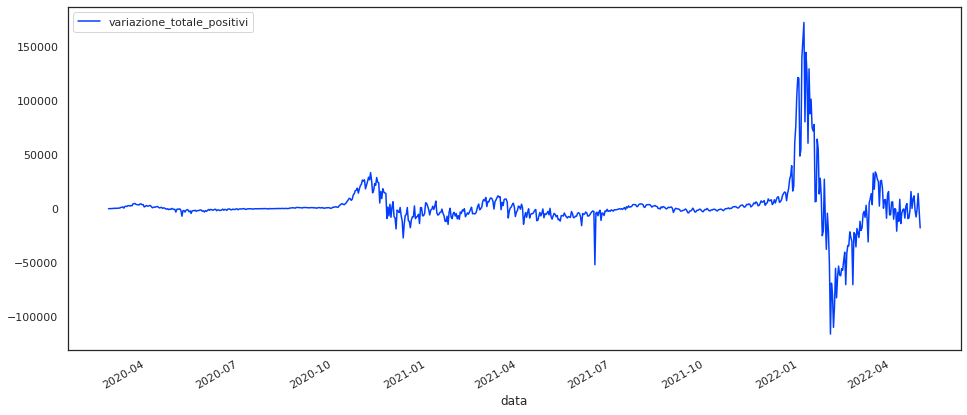

In [20]:
IT_cases.plot('data', 'variazione_totale_positivi', figsize=(16,7))

### Daily Variations

In [21]:
for col in ['ricoverati_con_sintomi', 
            'terapia_intensiva', 
            'totale_ospedalizzati', 
            'isolamento_domiciliare', 
            'totale_positivi', 
            'dimessi_guariti', 
            'deceduti', 
            'casi_da_sospetto_diagnostico', 
            'casi_da_screening',
            'totale_casi', 
            'tamponi', 
            'casi_testati',  
            'ingressi_terapia_intensiva',            
            'totale_positivi_test_molecolare',
            'totale_positivi_test_antigenico_rapido', 
            'tamponi_test_molecolare',
            'tamponi_test_antigenico_rapido']:
    IT_cases[col + '_var'] = IT_cases[col].diff()

### Measures and Restrictions

In [22]:
with open('COVID-19/aree/geojson/dpc-covid-19-aree-nuove-g.json') as f:
    _IT_measures_json = json.load(f)

In [23]:
IT_measures = pd.DataFrame([f['properties'] for f in _IT_measures_json['features']]).set_index('FID')
IT_measures.head(10)

localID  namespace versionID ID_Evento       ID_EventoS nomeLingua  \
FID                                                                      
0            IT.PCMDPC        01         1  COVID-19-Italia        ita   
1            IT.PCMDPC        01         1  COVID-19-Italia        ita   
2            IT.PCMDPC        01         1  COVID-19-Italia        ita   
3            IT.PCMDPC        01         1  COVID-19-Italia        ita   
4            IT.PCMDPC        01         1  COVID-19-Italia        ita   
5            IT.PCMDPC        01         1  COVID-19-Italia        ita   
6            IT.PCMDPC        01         1  COVID-19-Italia        ita   
7            IT.PCMDPC        01         1  COVID-19-Italia        ita   
8            IT.PCMDPC        01         1  COVID-19-Italia        ita   
9            IT.PCMDPC        01         1  COVID-19-Italia        ita   

         nomeStatus nomeOrigin   nomePronun      nomeFonte  ... legSpecRif  \
FID                                                         ...              
0    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.3   
1    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.1   
2    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.1   
3    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.3   
4    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.1   
5    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.3   
6    standardizzato   endonimo  unpopulated  provISTAT2020  ...      art.1   
7    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.2   
8    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.1   
9    standardizzato   endonimo  unpopulated   regISTAT2020  ...      art.2   

        legNumID legDocUff     legDataApp  legDataAbr   legLivello  \
FID                                                                  
0    unpopulated   unknown  1604620800000     unknown    regionale   
1    unpopulated   unknown  1604620800000     unknown    regionale   
2    unpopulated   unknown  1604620800000     unknown    regionale   
3    unpopulated   unknown  1604620800000     unknown    regionale   
4    unpopulated   unknown  1604620800000     unknown    regionale   
5    unpopulated   unknown  1604620800000     unknown    regionale   
6    unpopulated   unknown  1604620800000     unknown  provinciale   
7    unpopulated   unknown  1604620800000     unknown    regionale   
8    unpopulated   unknown  1604620800000     unknown    regionale   
9    unpopulated   unknown  1604620800000     unknown    regionale   

           legGU_ID   legGU_ISSN   legGU_ISBN  \
FID                                             
0    276 05/11/2020  unpopulated  unpopulated   
1    275 04/11/2020  unpopulated  unpopulated   
2    275 04/11/2020  unpopulated  unpopulated   
3    276 05/11/2020  unpopulated  unpopulated   
4    275 04/11/2020  unpopulated  unpopulated   
5    276 05/11/2020  unpopulated  unpopulated   
6    275 04/11/2020  unpopulated  unpopulated   
7    276 05/11/2020  unpopulated  unpopulated   
8    275 04/11/2020  unpopulated  unpopulated   
9    276 05/11/2020  unpopulated  unpopulated   

                                            legGU_Link  
FID                                                     
0    https://www.gazzettaufficiale.it/eli/id/2020/1...  
1    https://www.gazzettaufficiale.it/eli/id/2020/1...  
2    https://www.gazzettaufficiale.it/eli/id/2020/1...  
3    https://www.gazzettaufficiale.it/eli/id/2020/1...  
4    https://www.gazzettaufficiale.it/eli/id/2020/1...  
5    https://www.gazzettaufficiale.it/eli/id/2020/1...  
6    https://www.gazzettaufficiale.it/eli/id/2020/1...  
7    https://www.gazzettaufficiale.it/eli/id/2020/1...  
8    https://www.gazzettaufficiale.it/eli/id/2020/1...  
9    https://www.gazzettaufficiale.it/eli/id/2020/1...  

[10 rows x 36 columns]

In [24]:
IT_measures['legLivello'].value_counts()

regionale      364
provinciale     37
nazionale        8
Name: legLivello, dtype: int64

### Date columns

In [25]:
for col in ['legData', 'legDataApp', 'designIniz']:
    IT_measures[col] = pd.to_datetime(IT_measures[col], unit='ms')

In [26]:
IT_measures[['legData', 'legDataApp', 'designIniz']][:10]

legData legDataApp designIniz
FID                                 
0   2020-11-04 2020-11-06 2020-11-06
1   2020-11-03 2020-11-06 2020-11-06
2   2020-11-03 2020-11-06 2020-11-06
3   2020-11-04 2020-11-06 2020-11-06
4   2020-11-03 2020-11-06 2020-11-06
5   2020-11-04 2020-11-06 2020-11-06
6   2020-11-03 2020-11-06 2020-11-06
7   2020-11-04 2020-11-06 2020-11-06
8   2020-11-03 2020-11-06 2020-11-06
9   2020-11-04 2020-11-06 2020-11-06

In [27]:
IT_measures['designFine'] = pd.to_datetime(IT_measures['designFine'].str.strip(), format='%d/%m/%Y', errors='coerce')

In [28]:
IT_measures['designFine'][:10]

FID
0   2020-11-20
1   2020-12-03
2   2020-12-03
3   2020-11-20
4   2020-12-03
5   2020-11-20
6   2020-12-03
7   2020-11-20
8   2020-12-03
9   2020-11-20
Name: designFine, dtype: datetime64[ns]

In [29]:
IT_measures[IT_measures['legLivello'] == 'nazionale']

localID  namespace versionID ID_Evento       ID_EventoS nomeLingua  \
FID                                                                      
67           IT.PCMDPC        10         1  COVID-19-Italia        ita   
68           IT.PCMDPC        11         1  COVID-19-Italia        ita   
69           IT.PCMDPC        12         1  COVID-19-Italia        ita   
70           IT.PCMDPC        13         1  COVID-19-Italia        ita   
71           IT.PCMDPC        14         1  COVID-19-Italia        ita   
72           IT.PCMDPC        15         1  COVID-19-Italia        ita   
73           IT.PCMDPC        16         1  COVID-19-Italia        ita   
193          IT.PCMDPC        29         1  COVID-19-Italia        ita   

         nomeStatus nomeOrigin   nomePronun       nomeFonte  ... legSpecRif  \
FID                                                          ...              
67   standardizzato   endonimo  unpopulated  DL18/12/20 172  ...      art.3   
68   standardizzato   endonimo  unpopulated  DL18/12/20 172  ...      art.2   
69   standardizzato   endonimo  unpopulated  DL18/12/20 172  ...      art.3   
70   standardizzato   endonimo  unpopulated  DL18/12/20 172  ...      art.2   
71   standardizzato   endonimo  unpopulated  DL18/12/20 172  ...      art.3   
72   standardizzato   endonimo  unpopulated   DL 05/01/21 1  ...      art.1   
73   standardizzato   endonimo  unpopulated   DL 05/01/21 1  ...      art.2   
193  standardizzato   endonimo  unpopulated  DL 13/03/21 30  ...      art.3   

        legNumID legDocUff legDataApp   legDataAbr legLivello        legGU_ID  \
FID                                                                             
67   unpopulated   unknown 2020-12-24  unpopulated  nazionale  313 18/12/2020   
68   unpopulated   unknown 2020-12-24  unpopulated  nazionale  313 18/12/2020   
69   unpopulated   unknown 2020-12-24  unpopulated  nazionale  313 18/12/2020   
70   unpopulated   unknown 2020-12-24  unpopulated  nazionale  313 18/12/2020   
71   unpopulated   unknown 2020-12-24  unpopulated  nazionale  313 18/12/2020   
72   unpopulated   unknown 2021-01-06  unpopulated  nazionale    3 05/01/2021   
73   unpopulated   unknown 2021-01-06  unpopulated  nazionale    3 05/01/2021   
193  unpopulated   unknown 2021-03-13      unknown  nazionale   62 13/03/2021   

      legGU_ISSN   legGU_ISBN  \
FID                             
67   unpopulated  unpopulated   
68   unpopulated  unpopulated   
69   unpopulated  unpopulated   
70   unpopulated  unpopulated   
71   unpopulated  unpopulated   
72   unpopulated  unpopulated   
73   unpopulated  unpopulated   
193  unpopulated  unpopulated   

                                            legGU_Link  
FID                                                     
67   https://www.gazzettaufficiale.it/eli/id/2020/1...  
68   https://www.gazzettaufficiale.it/eli/id/2020/1...  
69   https://www.gazzettaufficiale.it/eli/id/2020/1...  
70   https://www.gazzettaufficiale.it/eli/id/2020/1...  
71   https://www.gazzettaufficiale.it/eli/id/2020/1...  
72   https://www.gazzettaufficiale.it/eli/id/2021/0...  
73   https://www.gazzettaufficiale.it/eli/id/2021/0...  
193  https://www.gazzettaufficiale.it/eli/id/2021/0...  

[8 rows x 36 columns]

### Vaccinations

In [30]:
IT_vacc = pd.read_csv('covid19-opendata-vaccini/dati/somministrazioni-vaccini-latest.csv')
IT_vacc.head(20)

data_somministrazione        fornitore area fascia_anagrafica  \
0             2020-12-27          Moderna  LAZ             40-49   
1             2020-12-27          Moderna  SIC               90+   
2             2020-12-27  Pfizer/BioNTech  ABR             20-29   
3             2020-12-27  Pfizer/BioNTech  ABR             30-39   
4             2020-12-27  Pfizer/BioNTech  ABR             40-49   
5             2020-12-27  Pfizer/BioNTech  ABR             50-59   
6             2020-12-27  Pfizer/BioNTech  ABR             60-69   
7             2020-12-27  Pfizer/BioNTech  ABR             70-79   
8             2020-12-27  Pfizer/BioNTech  ABR             80-89   
9             2020-12-27  Pfizer/BioNTech  BAS             20-29   
10            2020-12-27  Pfizer/BioNTech  BAS             30-39   
11            2020-12-27  Pfizer/BioNTech  BAS             40-49   
12            2020-12-27  Pfizer/BioNTech  BAS             50-59   
13            2020-12-27  Pfizer/BioNTech  BAS             60-69   
14            2020-12-27  Pfizer/BioNTech  CAL             20-29   
15            2020-12-27  Pfizer/BioNTech  CAL             30-39   
16            2020-12-27  Pfizer/BioNTech  CAL             40-49   
17            2020-12-27  Pfizer/BioNTech  CAL             50-59   
18            2020-12-27  Pfizer/BioNTech  CAL             60-69   
19            2020-12-27  Pfizer/BioNTech  CAM             20-29   

    sesso_maschile  sesso_femminile  prima_dose  seconda_dose  \
0                0                1           1             0   
1                0                1           1             0   
2                1                1           2             0   
3                1                4           5             0   
4                1                8           9             0   
5                7                6          13             0   
6               12                4          16             0   
7                1                0           1             0   
8                1                0           1             0   
9                4                5           9             0   
10              10               18          28             0   
11               7               24          31             0   
12              11               15          26             0   
13               9                4          13             0   
14              18               42          60             0   
15              25               25          50             0   
16              25               32          57             0   
17              57               31          88             0   
18              45               18          63             0   
19              27               33          60             0   

    pregressa_infezione  dose_addizionale_booster  booster_immuno  d2_booster  \
0                     0                         0               0           0   
1                     0                         0               0           0   
2                     0                         0               0           0   
3                     0                         0               0           0   
4                     0                         0               0           0   
5                     0                         0               0           0   
6                     0                         0               0           0   
7                     0                         0               0           0   
8                     0                         0               0           0   
9                     0                         0               0           0   
10                    0                         0               0           0   
11                    0                         0               0           0   
12                    0                         0               0           0   
13                    0                         0               0         

In [31]:
IT_vacc['data_somministrazione'] = pd.to_datetime(IT_vacc['data_somministrazione']) 

In [32]:
# Grouping Vaccinations By Date

# NOTE on "pregressa_infezione": Numero di somministrazioni effettuate a soggetti con pregressa infezione da covid-19 nel periodo 3-6 mesi e che, pertanto, concludono il ciclo vaccinale con un'unica dose
IT_vacc_grouped = IT_vacc.groupby('data_somministrazione')[['prima_dose', 'seconda_dose', 'pregressa_infezione', 'dose_addizionale_booster', 'booster_immuno']].sum().reset_index()
IT_vacc_grouped.head()

data_somministrazione  prima_dose  seconda_dose  pregressa_infezione  \
0            2020-12-27        7333             0                   17   
1            2020-12-28        1503             0                    2   
2            2020-12-29        1098             0                    1   
3            2020-12-30        4881             0                    6   
4            2020-12-31       25907             0                   42   

   dose_addizionale_booster  booster_immuno  
0                         0               0  
1                         0               0  
2                         0               0  
3                         0               0  
4                         0               0

In [33]:
IT_vacc_grouped.sum()

/tmp/ipykernel_185545/3725070714.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  IT_vacc_grouped.sum()


prima_dose                  48811241
seconda_dose                46398898
pregressa_infezione          1951239
dose_addizionale_booster    39346492
booster_immuno                123972
dtype: int64

In [34]:
# Building cumulated sums
IT_vacc_grouped['prima_dose_totali'] = IT_vacc_grouped['prima_dose'].cumsum()
IT_vacc_grouped['seconda_dose_totali'] = IT_vacc_grouped['seconda_dose'].cumsum() + IT_vacc_grouped['pregressa_infezione'].cumsum()
IT_vacc_grouped['dose_addizionale_booster_totali'] = IT_vacc_grouped['dose_addizionale_booster'].cumsum() + IT_vacc_grouped['booster_immuno'].cumsum()

In [35]:
# Building population vaccination state counters 
IT_vacc_grouped['non_vaccinati'] = IT_population * 1000 - IT_vacc_grouped['prima_dose_totali']
IT_vacc_grouped['prima_dose_totali'] -= IT_vacc_grouped['seconda_dose_totali']
IT_vacc_grouped['seconda_dose_totali'] -= IT_vacc_grouped['dose_addizionale_booster_totali']

In [36]:
# Over 50s
fasce_anagrafiche = [f'{i*10}-{i*10+9}' for i in range(5,9)] + ['90+']
fasce_anagrafiche

['50-59', '60-69', '70-79', '80-89', '90+']

In [37]:
# Grouping Over50 Vaccinations By Date

# NOTE on "pregressa_infezione": Numero di somministrazioni effettuate a soggetti con pregressa infezione da covid-19 nel periodo 3-6 mesi e che, pertanto, concludono il ciclo vaccinale con un'unica dose
IT_vacc_grouped_over50 = IT_vacc[IT_vacc['fascia_anagrafica'].isin(fasce_anagrafiche)].groupby('data_somministrazione')[['prima_dose', 'seconda_dose', 'pregressa_infezione', 'dose_addizionale_booster', 'booster_immuno']].sum().reset_index()
IT_vacc_grouped_over50.head()

data_somministrazione  prima_dose  seconda_dose  pregressa_infezione  \
0            2020-12-27        4034             0                   13   
1            2020-12-28         682             0                    0   
2            2020-12-29         558             0                    0   
3            2020-12-30        2249             0                    0   
4            2020-12-31       13233             0                   25   

   dose_addizionale_booster  booster_immuno  
0                         0               0  
1                         0               0  
2                         0               0  
3                         0               0  
4                         0               0

In [38]:
IT_vacc_grouped_over50.sum()

/tmp/ipykernel_185545/3660445289.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  IT_vacc_grouped_over50.sum()


prima_dose                  25161949
seconda_dose                23884677
pregressa_infezione           885062
dose_addizionale_booster    23093375
booster_immuno                114334
dtype: int64

In [39]:
IT_vacc_grouped_over50['prima_dose_totali'] = IT_vacc_grouped_over50['prima_dose'].cumsum()
IT_vacc_grouped_over50['seconda_dose_totali'] = IT_vacc_grouped_over50['seconda_dose'].cumsum() + IT_vacc_grouped_over50['pregressa_infezione'].cumsum()
# IT_vacc_grouped_over50['pregressa_infezione_totali'] = IT_vacc_grouped_over50['pregressa_infezione'].cumsum()
IT_vacc_grouped_over50['dose_addizionale_booster_totali'] = IT_vacc_grouped_over50['dose_addizionale_booster'].cumsum() + IT_vacc_grouped_over50['booster_immuno'].cumsum()

In [40]:
IT_vacc_grouped_over50['non_vaccinati'] = IT_population_over50 * 1000 - IT_vacc_grouped_over50['prima_dose_totali']
IT_vacc_grouped_over50['prima_dose_totali'] -= IT_vacc_grouped_over50['seconda_dose_totali']
IT_vacc_grouped_over50['seconda_dose_totali'] -= IT_vacc_grouped_over50['dose_addizionale_booster_totali']

# ANALYSIS

### Utilities and globals

In [41]:
start_date = dt(2021, 6, 1)
end_date = dt(2022, 5, 1)
figsize = (24, 9)
vert_offset = 80

In [42]:
def print_vert_line(ax, d, t, color, linestyle='dashed'):
    ax.axvline(d+shift, color=color, linestyle=linestyle)
    vert_shift = vert_offset - len(t)
    ax.text(d,0, ' ' * vert_shift + t,rotation=90)

In [43]:
def clean_title(title, replace_dict={' ': '_'}, drop_list=['(', ')', '%', ':']):
    for k, v in replace_dict.items():
        title = title.replace(k, v)
    for k in drop_list:
        title = title.replace(k, '')
    return title.strip('_')[:35].strip('_')

def save_fig(figure_or_axes, title):
    title = clean_title(title)
    if hasattr(figure_or_axes, 'get_figure'):
        figure_or_axes = figure_or_axes.get_figure()
    figure_or_axes.savefig(f'./imgs/{title}.jpg')

In [44]:
# Color codes:
class Color:
    DEATH = 'tomato'
    INTENSIVE_CARE = 'sandybrown'
    IN_HOSPITAL = 'c'
    QUARANTINED = 'salmon'  # Isolamento domiciliare
    AVAILABLE_BEDS = 'turquoise'
    UNVACCINATED = 'palegreen'
    FIRST_DOSE = 'lightcoral'
    SECOND_DOSE = 'dodgerblue'
    THIRD_DOSE = 'violet'

# UK Analysis

In [45]:
# General data https://www.instituteforgovernment.org.uk/charts/uk-government-coronavirus-lockdowns
dates_stop_restrictions_ENG = [
    (dt(2021, 6, 14), 'R: Nessuna restrizione matrimoni e funerali'),      
    (dt(2021, 7, 19), 'R: Rimozione quasi totale restrizioni, apertura totale esercizi (es. discoteche)'),  
    (dt(2022, 2, 24), 'R: Rimozione completa restrizioni'),  # https://news.sky.com/story/covid-19-all-remaining-coronavirus-restrictions-lifted-in-england-12549571
]
dates_laws_ENG = [
    (dt(2021, 9, 12), 'L: Presentazione "piano B"'),
    (dt(2021, 12, 8), 'L: Attivazione piano B')
]
dates_covid_UK = [
    (dt(2021, 11, 27), 'Primo caso inglese omicron'),  # https://www.gov.uk/government/news/first-uk-cases-of-omicron-variant-identified
]
dates_restrictions_ENG = [
    (dt(2021, 12, 10), 'R: Mascherine obbligatorie al chiuso'),  # 
    (dt(2021, 12, 15), 'CP: Obbligatorio per grandi eventi'),  # NOTE: CovidPass, NON GreenPass: si può ottenere anche con un test. Eventi da 500 o più persone. https://www.gov.uk/government/news/prime-minister-confirms-move-to-plan-b-in-england
]

Al 1 Giugno 2021, il Regno Unito era alle ultima fasi di uscita del secondo lockdown. 
In Inghilterra: 
 - 8 Marzo 2021: Apertura scuole
 - 29 Marzo 2021: Incontri all'aperto di fino a 6 persone o 2 case. Fine dell'obbligo di rimanere in casa.
 - 12 Aprile 2021: Riapertura musei, parrucchieri, negozi non essenziali, ristoranti all'aperto.
 - 17 Maggio 2021: fino a 30 persone si possono riunire all'aperto. 6 persone o fino a 2 nuclei famigliari si possono riunire al chiuso. Riapertura ristoranti al chiuso ed eventi all'aperto fino a 10 mila spettatori.
 - 14 Giugno 2021: Nessuna restrizione su matrimoni e funerali.

In [46]:
UK = UK_data[UK_data['date'] >= start_date]

In [47]:
UK_death_since_june21 = UK['newDeaths28DaysByDeathDate'].sum() / 1000
UK_cases_since_june21 = UK['newCasesBySpecimenDate'].sum() / 1000

In [48]:
print(f'La popolazione del Regno Unito è di {UK_population / 1000} milioni, di cui {UK_population_over50 / 1000} milioni di over50 ({UK_population_over50 / UK_population*100:.02f}%)')

La popolazione del Regno Unito è di 67.22 milioni, di cui 25.491 milioni di over50 (37.92%)


In [49]:
print(f'Dall\'inizio dell\'epidemia ci sono stati {UK_cases_total / 1000} milioni di casi '
      f'({UK_cases_total / UK_population * 100 * 1000:.0f} casi ogni 100 mila abitanti, {UK_cases_total / UK_population_over50 * 100 * 1000:.0f} casi ogni 100 mila abitanti over50), '
      f'\ncon {UK_death_total * 1000} decessi '
      f'({UK_death_total / UK_population * 100 * 1000:.0f} decessi ogni 100 mila abitanti, {UK_death_total / UK_population_over50 * 100 * 1000:.0f} decessi ogni 100 mila abitanti over50)')

Dall'inizio dell'epidemia ci sono stati 22.0 milioni di casi (32728 casi ogni 100 mila abitanti, 86305 casi ogni 100 mila abitanti over50), 
con 174000 decessi (259 decessi ogni 100 mila abitanti, 683 decessi ogni 100 mila abitanti over50)


In [50]:
print(f'Da giugno 2021 ci sono stati {UK_cases_since_june21 / 1000:,.02f} milioni di casi '
      f'({UK_cases_since_june21 / UK_population * 100 * 1000:.0f} casi ogni 100 mila abitanti, {UK_cases_since_june21 / UK_population_over50 * 100 * 1000:.0f} casi ogni 100 mila abitanti over50), '
      f'\ncon {UK_death_since_june21 * 1000:.0f} decessi '
      f'({UK_death_since_june21 / UK_population * 100 * 1000:.0f} decessi ogni 100 mila abitanti, {UK_death_since_june21 / UK_population_over50 * 100 * 1000:.0f} decessi ogni 100 mila abitanti over50)')

Da giugno 2021 ci sono stati 17.46 milioni di casi (25967 casi ogni 100 mila abitanti, 68475 casi ogni 100 mila abitanti over50), 
con 46568 decessi (69 decessi ogni 100 mila abitanti, 183 decessi ogni 100 mila abitanti over50)


In [51]:
print(f'Il Regno Unito ha a disposizione circa {UK_ICU_beds:.0f} letti in terapia intensiva, '
      f'circa {UK_ICU_beds/UK_population * 100:.0f} ogni 100 mila abitanti '
      f'({UK_ICU_beds/UK_population_over50 * 100:.0f} ogni 100 mila abitanti over50)')

Il Regno Unito ha a disposizione circa 6000 letti in terapia intensiva, circa 9 ogni 100 mila abitanti (24 ogni 100 mila abitanti over50)


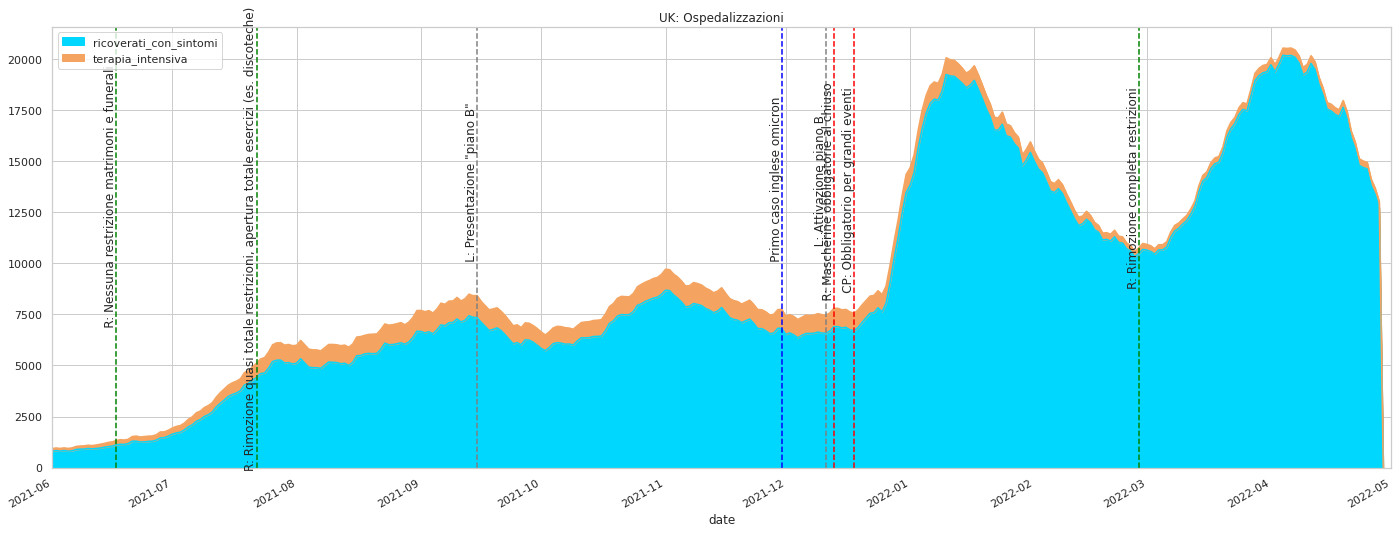

In [52]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")


temp_UK = UK[:][['date', 'hospitalCases', 'covidOccupiedMVBeds']]
temp_UK['hospitalCasesNotMV'] = temp_UK['hospitalCases'] - temp_UK['covidOccupiedMVBeds']

title = 'UK: Ospedalizzazioni'
ax = temp_UK[['date', 'hospitalCasesNotMV', 'covidOccupiedMVBeds']].plot.area(x='date', 
                                                                              figsize=figsize, 
                                                                              stacked=True, 
                                                                              xlim=(start_date, end_date),
                                                                              title=title,
                                                                              color=[Color.IN_HOSPITAL, Color.INTENSIVE_CARE])
legend_elements = [
    Patch(color=Color.IN_HOSPITAL, label='ricoverati_con_sintomi'),
    Patch(color=Color.INTENSIVE_CARE, label='terapia_intensiva')
]
ax.legend(handles=legend_elements, loc='upper left')
shift = td(days=3)

for d, t in dates_restrictions_ENG:
    print_vert_line(ax, d, t, "red")
for d, t in dates_laws_ENG:
    print_vert_line(ax, d, t, "grey")
for d, t in dates_stop_restrictions_ENG:
    print_vert_line(ax, d, t, "green")
for d, t in dates_covid_UK:
    print_vert_line(ax, d, t, "blue")

save_fig(ax, title)

Nel periodo considerato nel Regno Unito vi sono stati 46568.0 decessi, con un picco giornaliero di 306.0 decessi


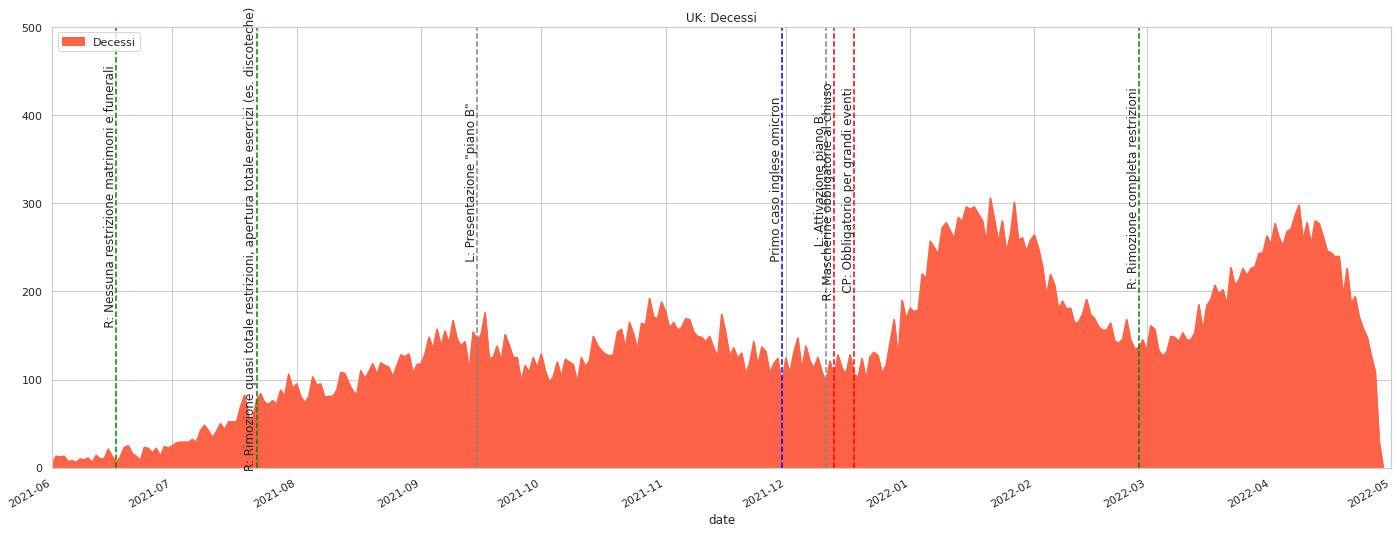

In [54]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

title = 'UK: Decessi'
ax = UK[['date', 'newDeaths28DaysByDeathDate']].plot.area(x='date', 
                                                          figsize=figsize, 
                                                          stacked=True, 
                                                          xlim=(start_date, end_date),
                                                          ylim=(0, 500),
                                                          color=Color.DEATH,
                                                          title=title)
legend_elements = [
    Patch(color=Color.DEATH, label='Decessi')
]
ax.legend(handles=legend_elements, loc='upper left')
shift = td(days=3)

for d, t in dates_restrictions_ENG:
    print_vert_line(ax, d, t, "red")
for d, t in dates_laws_ENG:
    print_vert_line(ax, d, t, "grey")
for d, t in dates_stop_restrictions_ENG:
    print_vert_line(ax, d, t, "green")
for d, t in dates_covid_UK:
    print_vert_line(ax, d, t, "blue")

save_fig(ax, title)

print(f'Nel periodo considerato nel Regno Unito vi sono stati {UK["newDeaths28DaysByDeathDate"].sum()} decessi, con un picco giornaliero di {UK["newDeaths28DaysByDeathDate"].max()} decessi')

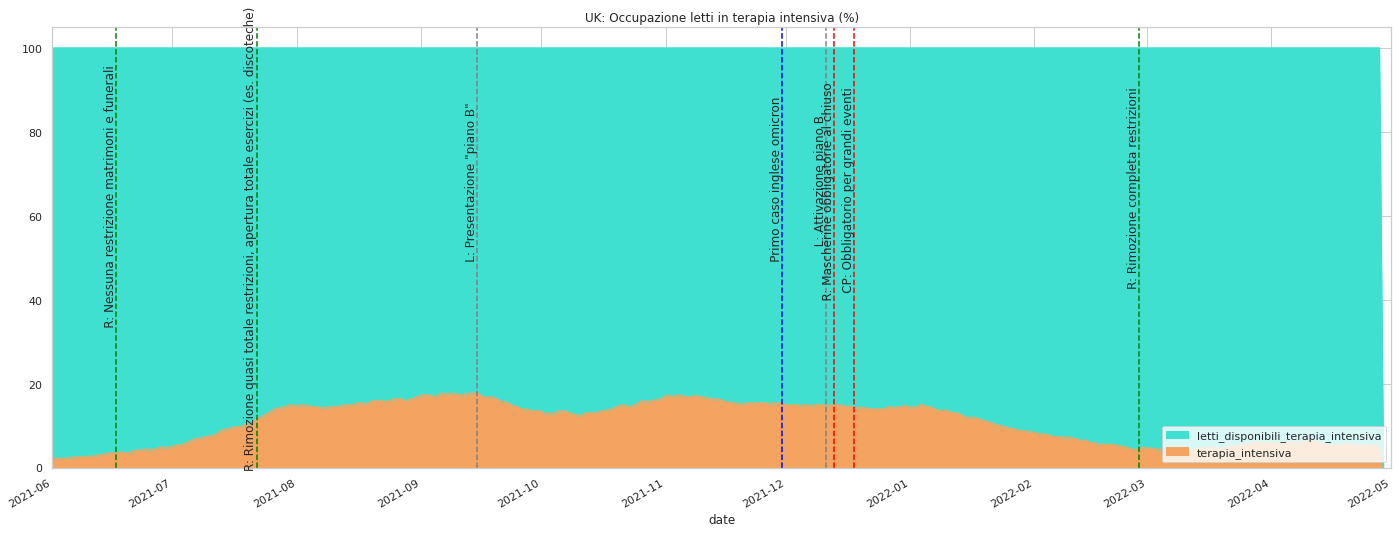

In [55]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

# 'newDeaths28DaysByDeathDate', 'newDailyNsoDeathsByDeathDate'
temp_df = UK[['date', 'letti_disponibili_terapia_intensiva', 'covidOccupiedMVBeds']].copy()
temp_df['letti_disponibili_terapia_intensiva'] = temp_df['letti_disponibili_terapia_intensiva'] / UK_ICU_beds * 100
temp_df['covidOccupiedMVBeds'] = temp_df['covidOccupiedMVBeds'] / UK_ICU_beds * 100

title = f'UK: Occupazione letti in terapia intensiva (%)'
ax = temp_df[['date', 'covidOccupiedMVBeds', 'letti_disponibili_terapia_intensiva', ]].plot.area(x='date', 
                                                                                               figsize=figsize, 
                                                                                               stacked=True, 
                                                                                               xlim=(start_date, end_date),
                                                                                               title=title,
                                                                                               color=[Color.INTENSIVE_CARE, Color.AVAILABLE_BEDS])
legend_elements = [
    Patch(color=Color.AVAILABLE_BEDS, label='letti_disponibili_terapia_intensiva'),
    Patch(color=Color.INTENSIVE_CARE, label='terapia_intensiva'),
]
ax.legend(handles=legend_elements, loc='lower right')
shift = td(days=3)

for d, t in dates_restrictions_ENG:
    print_vert_line(ax, d, t, "red")
for d, t in dates_laws_ENG:
    print_vert_line(ax, d, t, "grey")
for d, t in dates_stop_restrictions_ENG:
    print_vert_line(ax, d, t, "green")
for d, t in dates_covid_UK:
    print_vert_line(ax, d, t, "blue")

save_fig(ax, title)

## Vaccinations

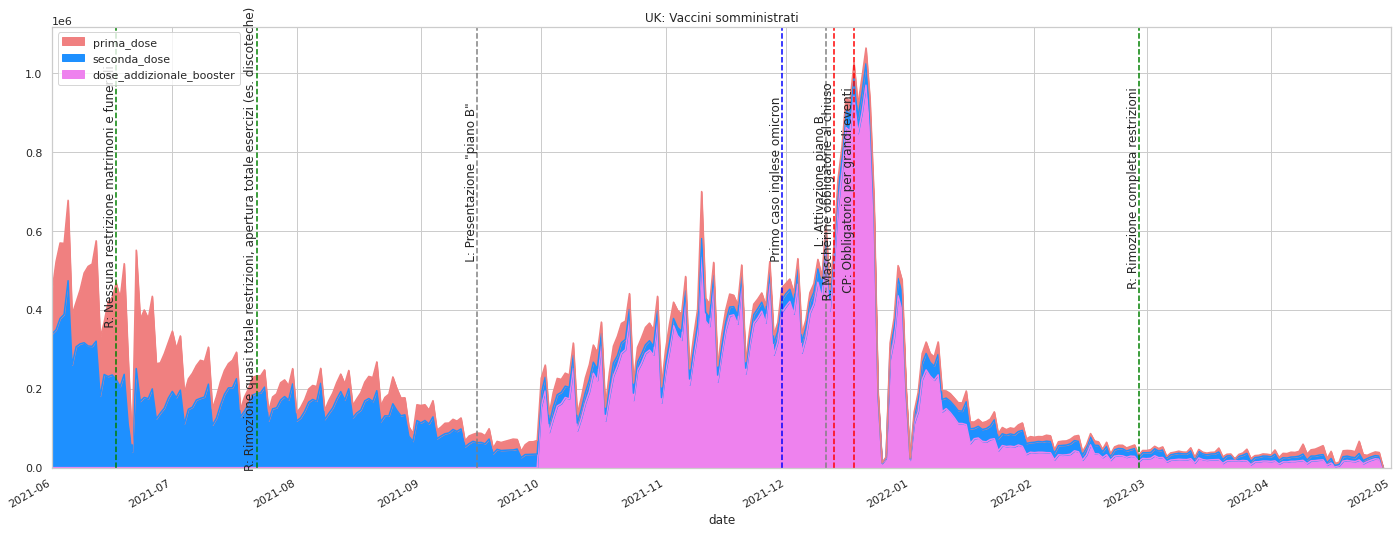

In [56]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

# NOTE: Third dose and booster are NOT the same https://sbuhb.nhs.wales/go/covid-19-vaccinations-third-dose-for-the-immunosuppressed-not-boosters/

title = 'UK: Vaccini somministrati'

ax = UK[:][['date', 'newPeopleVaccinatedThirdInjectionByPublishDate', 
            'newPeopleVaccinatedSecondDoseByPublishDate', 
            'newPeopleVaccinatedFirstDoseByPublishDate']].plot.area(x='date', 
                                                                    figsize=figsize, 
                                                                    stacked=True, 
                                                                    xlim=(start_date, end_date),
                                                                    color=[Color.THIRD_DOSE, Color.SECOND_DOSE, Color.FIRST_DOSE],
                                                                    title=title)
legend_elements = [
    Patch(color=Color.FIRST_DOSE, label='prima_dose'),
    Patch(color=Color.SECOND_DOSE, label='seconda_dose'),
    Patch(color=Color.THIRD_DOSE, label='dose_addizionale_booster')        
]
ax.legend(handles=legend_elements, loc='upper left')
shift = td(days=3)

for d, t in dates_restrictions_ENG:
    print_vert_line(ax, d, t, "red")
for d, t in dates_laws_ENG:
    print_vert_line(ax, d, t, "grey")
for d, t in dates_stop_restrictions_ENG:
    print_vert_line(ax, d, t, "green")
for d, t in dates_covid_UK:
    print_vert_line(ax, d, t, "blue")

save_fig(ax, title)

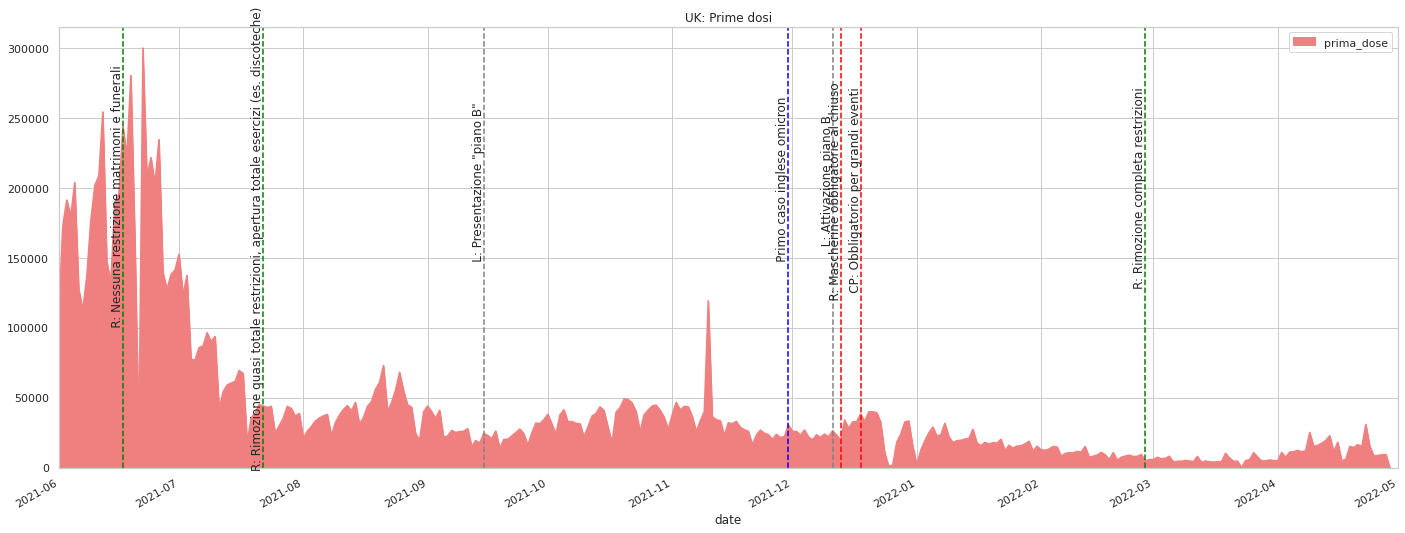

In [57]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

# NOTE: Third dose and booster are NOT the same https://sbuhb.nhs.wales/go/covid-19-vaccinations-third-dose-for-the-immunosuppressed-not-boosters/

title = 'UK: Prime dosi'
ax = UK[:][['date', 
            'newPeopleVaccinatedFirstDoseByPublishDate']].plot.area(x='date', 
                                                                    figsize=figsize, 
                                                                    stacked=True, 
                                                                    xlim=(start_date, end_date),
                                                                   title=title,
                                                                   color=Color.FIRST_DOSE)
shift = td(days=3)

legend_elements = [
    Patch(color=Color.FIRST_DOSE, label='prima_dose'),
]
ax.legend(handles=legend_elements, loc='upper right')
shift = td(days=3)

for d, t in dates_restrictions_ENG:
    print_vert_line(ax, d, t, "red")
for d, t in dates_laws_ENG:
    print_vert_line(ax, d, t, "grey")
for d, t in dates_stop_restrictions_ENG:
    print_vert_line(ax, d, t, "green")
for d, t in dates_covid_UK:
    print_vert_line(ax, d, t, "blue")

save_fig(ax, title)

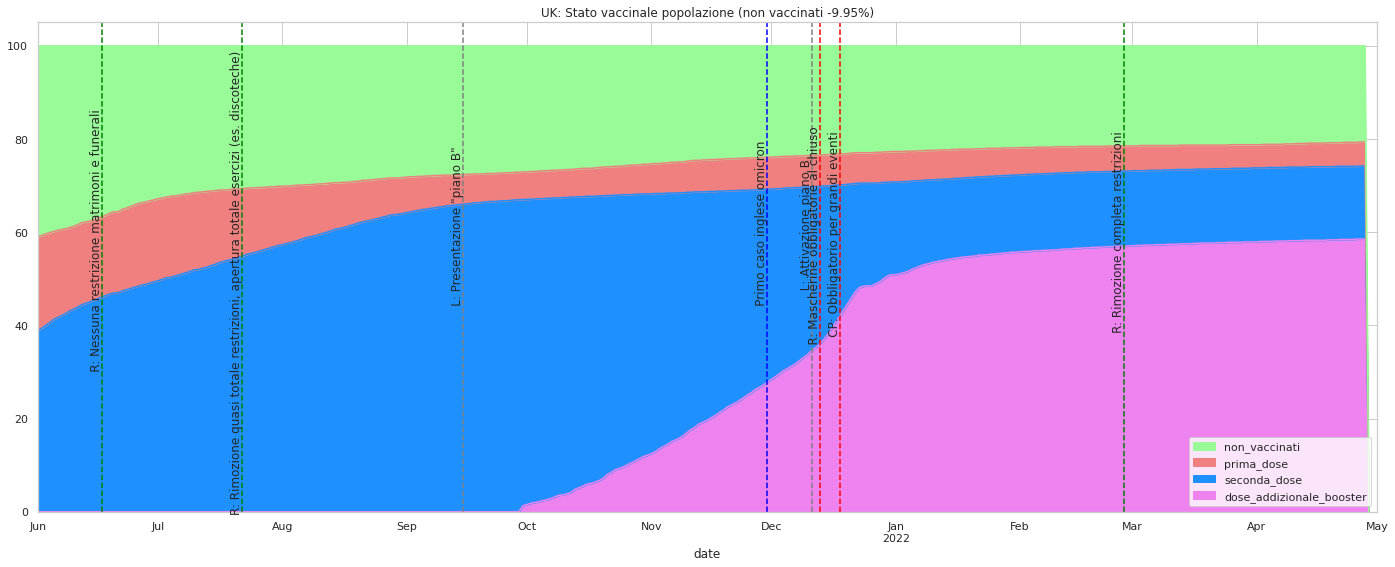

In [58]:
# Overview

#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

cols = ['dose_addizionale_booster_totali', 'seconda_dose_totali', 'prima_dose_totali', 'non_vaccinati']
temp_df = UK[:][['date'] + cols].sort_values('date')

diff_vaccinati = temp_df['non_vaccinati'].iloc[0] - temp_df['non_vaccinati'].iloc[-2]  # 
diff_vaccinati = temp_df['non_vaccinati'].iloc[-2] - temp_df['non_vaccinati'][temp_df['date'] == dt(2021, 7, 23)].iloc[0]  # Since first GP law
# diff_vaccinati = temp_df['non_vaccinati'].iloc[-1] - temp_df['non_vaccinati'][temp_df['data_somministrazione'] == dates_laws_italy[0][0]].iloc[0]  # Since first GP law

title = f'UK: Stato vaccinale popolazione (non vaccinati {diff_vaccinati:.02f}%)'
ax = temp_df.plot.area(x='date', 
                       figsize=figsize, 
                       stacked=True, 
                       xlim=(start_date, end_date),
                       title=title,
                       color=[Color.THIRD_DOSE, Color.SECOND_DOSE, Color.FIRST_DOSE, Color.UNVACCINATED])

legend_elements = [
    Patch(color=Color.UNVACCINATED, label='non_vaccinati'),
    Patch(color=Color.FIRST_DOSE, label='prima_dose'),
    Patch(color=Color.SECOND_DOSE, label='seconda_dose'),
    Patch(color=Color.THIRD_DOSE, label='dose_addizionale_booster')        
]
ax.legend(handles=legend_elements, loc='lower right')
shift = td(days=3)

for d, t in dates_restrictions_ENG:
    print_vert_line(ax, d, t, "red")
for d, t in dates_laws_ENG:
    print_vert_line(ax, d, t, "grey")
for d, t in dates_stop_restrictions_ENG:
    print_vert_line(ax, d, t, "green")
for d, t in dates_covid_UK:
    print_vert_line(ax, d, t, "blue")

save_fig(ax, title)

# Italy Analysis

In [80]:
dates_GP_italy = [
    (dt(2021, 8, 6), 'GP: Musei, Rist., Palestre, Cineteatri'),  # https://www.rcovid19.it/green-pass-obbligatorio-dal-6-agosto/
    (dt(2021, 9, 1), 'GP: Pers.Scol., Università, Trasp. Nazionali'),  # https://www.ilrestodelcarlino.it/cronaca/green-pass-1-settembre-1.6753728
    (dt(2021, 12, 6), 'GP: Trasp. Locali | SuperGP: Rist., Palestre, Cineteatri'),  # https://www.ipsoa.it/documents/impresa/contratti-dimpresa/quotidiano/2021/12/06/super-green-pass-partono-6-dicembre-nuove-regole-anche-zona-bianca
    #https://www.today.it/attualita/super-green-pass-mezzi-pubblici-bus-tram-metro-6-dicembre-2021.html
    (dt(2021, 12, 15), 'Obbligo: Pers.Scol., Sociosanitari, Forze dell\'Ordine'),  # https://www.ipsoa.it/documents/impresa/contratti-dimpresa/quotidiano/2021/12/06/super-green-pass-partono-6-dicembre-nuove-regole-anche-zona-bianca
    (dt(2022, 1, 10), 'SuperGP: Ovunque'),  # https://www.ilgiorno.it/cronaca/super-green-pass-1.7226304
    (dt(2022, 2, 15), 'Obbligo: Over50'),  # https://www.ilgiorno.it/cronaca/super-green-pass-1.7226304
]

dates_covid_italy = [
    (dt(2021, 11, 27), 'Primo caso italiano omicron')  # https://www.ilgiorno.it/cronaca/covid-omicron-variante-primo-caso-sospetto-italia-campania-1.7085343
]

dates_laws_italy = [
    (dt(2021, 7, 23), 'DL: Musei, Rist., Palestre, Cineteatri'),  # https://www.altalex.com/documents/news/2021/07/23/green-pass-obbligatorio
    (dt(2021, 8, 5), 'DL: Pers.Scol., Università, Trasp. Nazionali'),  # https://www.ilrestodelcarlino.it/cronaca/green-pass-1-settembre-1.6753728
    (dt(2021, 11, 26), 'DL: GP Trasp.Locali | SuperGP: Rist. ecc. | Obbligo parziale'),  # https://www.altalex.com/documents/news/2021/11/25/super-green-pass-governo-ha-approvato-decreto-legge
    #https://www.today.it/attualita/super-green-pass-mezzi-pubblici-bus-tram-metro-6-dicembre-2021.html
    (dt(2021, 12, 30), 'DL: SuperGP Ovunque'),  # https://www.ilsole24ore.com/art/dal-10-gennaio-super-green-pass-ovunque-tranne-che-il-lavoro-e-lockdown-i-no-vax-AEYErT5
    (dt(2022, 1, 5), 'DL: Obbligo Over50'),  # https://www.lanazione.it/cronaca/obbligo-vaccinale-1.7216289
]
# Variante Delta in Italia https://www.ilfattoquotidiano.it/2021/06/12/focolaio-covid-in-una-palestra-di-milano-scoperti-10-casi-uno-e-di-variante-indiana/6228381/

In [81]:
IT = IT_cases[IT_cases['data'] >= start_date]

In [82]:
IT.describe()

ricoverati_con_sintomi  terapia_intensiva  totale_ospedalizzati  \
count              335.000000         335.000000            335.000000   
mean              7048.519403         642.952239           7691.471642   
std               5312.606620         413.583200           5676.875499   
min               1088.000000         151.000000           1242.000000   
25%               2971.500000         383.000000           3354.500000   
50%               4597.000000         488.000000           5157.000000   
75%               9999.000000         789.500000          10475.500000   
max              20037.000000        1717.000000          21728.000000   

       isolamento_domiciliare  totale_positivi  variazione_totale_positivi  \
count            3.350000e+02     3.350000e+02                  335.000000   
mean             6.457050e+05     6.533965e+05                 2919.304478   
std              7.585817e+05     7.640470e+05                32903.956474   
min              3.911900e+04     4.042600e+04              -116092.000000   
25%              9.123000e+04     9.426200e+04                -2861.500000   
50%              1.613210e+05     1.665980e+05                  309.000000   
75%              1.212401e+06     1.222968e+06                 4933.000000   
max              2.713594e+06     2.734906e+06               172462.000000   

       nuovi_positivi  dimessi_guariti       deceduti  \
count      335.000000     3.350000e+02     335.000000   
mean     36156.477612     6.703766e+06  138603.134328   
std      49309.939074     3.614344e+06   12020.205816   
min        389.000000     3.868332e+06  126221.000000   
25%       3688.000000     4.227553e+06  128825.000000   
50%       7975.000000     4.611566e+06  132819.000000   
75%      57802.500000     9.461628e+06  148934.000000   
max     220532.000000     1.507031e+07  163507.000000   

       casi_da_sospetto_diagnostico  ...  casi_da_sospetto_diagnostico_var  \
count                           0.0  ...                               0.0   
mean                            NaN  ...                               NaN   
std                             NaN  ...                               NaN   
min                             NaN  ...                               NaN   
25%                             NaN  ...                               NaN   
50%                             NaN  ...                               NaN   
75%                             NaN  ...                               NaN   
max                             NaN  ...                               NaN   

       casi_da_screening_var  totale_casi_var   tamponi_var  casi_testati_var  \
count                    0.0       335.000000  3.350000e+02      3.350000e+02   
mean                     NaN     36553.370149  4.406013e+05      8.564208e+04   
std                      NaN     50541.022450  2.914357e+05      1.136908e+05   
min                      NaN         0.000000  0.000000e+00      0.000000e+00   
25%                      NaN      3612.000000  2.227355e+05      5.255100e+04   
50%                      NaN      7972.000000  3.522650e+05      6.570000e+04   
75%                      NaN     57843.000000  5.561300e+05      9.268900e+04   
max                      NaN    228123.000000  1.481349e+06      1.970974e+06   

       ingressi_terapia_intensiva_var  totale_positivi_test_molecolare_var  \
count                      335.000000                           335.000000   
mean                        -0.017910                         13578.985075   
std                         13.881005                         18414.147911   
min                        -57.000000                        -23846.000000   
25%                         -7.000000                          3103.000000   
50%                         -1.000000                          6822.000000   
75%                          6.000000                         14214.500000   
max                         71.000000                         9631

In [83]:
IT.head()

data stato  ricoverati_con_sintomi  terapia_intensiva  \
463 2021-06-01   ITA                    6192                989   
464 2021-06-02   ITA                    5858                933   
465 2021-06-03   ITA                    5717                892   
466 2021-06-04   ITA                    5488                836   
467 2021-06-05   ITA                    5193                788   

     totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
463                  7181                  218570           225751   
464                  6791                  203259           210050   
465                  6609                  198953           205562   
466                  6324                  193868           200192   
467                  5981                  189388           195369   

     variazione_totale_positivi  nuovi_positivi  dimessi_guariti  ...  \
463                       -7923            2483          3868332  ...   
464                      -15701            2897          3886867  ...   
465                       -4488            1968          3893259  ...   
466                       -5370            2557          3901112  ...   
467                       -4823            2436          3908312  ...   

     casi_da_sospetto_diagnostico_var  casi_da_screening_var  totale_casi_var  \
463                               NaN                    NaN           2483.0   
464                               NaN                    NaN           2896.0   
465                               NaN                    NaN           1963.0   
466                               NaN                    NaN           2556.0   
467                               NaN                    NaN           2434.0   

     tamponi_var  casi_testati_var  ingressi_terapia_intensiva_var  \
463     221818.0           62470.0                             3.0   
464     226272.0           65900.0                            -8.0   
465      97633.0           35665.0                            -9.0   
466     220939.0           61028.0                            -2.0   
467     238632.0           67471.0                            -2.0   

    totale_positivi_test_molecolare_var  \
463                              2278.0   
464                              2705.0   
465                              1908.0   
466                              2335.0   
467                              2284.0   

     totale_positivi_test_antigenico_rapido_var  tamponi_test_molecolare_var  \
463                                       205.0                     105777.0   
464                                       191.0                     120026.0   
465                                        55.0                      62025.0   
466                                       221.0                     103912.0   
467                                       150.0                     113191.0   

     tamponi_test_antigenico_rapido_var  
463                            116041.0  
464                            106246.0  
465                             35608.0  
466                            117027.0  
467                            125441.0  

[5 rows x 42 columns]

In [84]:
# Since june 2021
IT_death_since_june21 = IT['deceduti_var'].sum() / 1000
IT_cases_since_june21 = IT['nuovi_positivi'].sum() / 1000

In [85]:
print(f'La popolazione italiana è di {IT_population / 1000} milioni, di cui {IT_population_over50 / 1000} milioni di over50 ({IT_population_over50/IT_population*100:.02f}%)')

La popolazione italiana è di 59.55 milioni, di cui 27.329 milioni di over50 (45.89%)


In [65]:
print(f'Dall\'inizio dell\'epidemia ci sono stati {IT_cases_total / 1000} milioni di casi '
      f'({IT_cases_total/IT_population * 100 * 1000:.0f} casi ogni 100 mila abitanti, {IT_cases_total/IT_population_over50 * 100 * 1000:.0f} casi ogni 100 mila abitanti over50), '
      f'\ncon {IT_death_total * 1000} decessi '
      f'({IT_death_total/IT_population * 100 * 1000:.0f} decessi ogni 100 mila abitanti, {IT_death_total/IT_population_over50 * 100 * 1000:.0f} decessi ogni 100 mila abitanti over50)')

Dall'inizio dell'epidemia ci sono stati 16.008 milioni di casi (26882 casi ogni 100 mila abitanti, 58575 casi ogni 100 mila abitanti over50), 
con 162000 decessi (272 decessi ogni 100 mila abitanti, 593 decessi ogni 100 mila abitanti over50)


In [88]:
print(f'Da giugno 2021 ci sono stati {IT_cases_since_june21 / 1000:,.02f} milioni di casi '
      f'({IT_cases_since_june21/IT_population * 100 * 1000:.0f} casi ogni 100 mila abitanti, {IT_cases_since_june21/IT_population_over50 * 100 * 1000:.0f} casi ogni 100 mila abitanti over50), '
      f'\ncon {IT_death_since_june21 * 1000:.0f} decessi '
      f'({IT_death_since_june21/IT_population * 100 * 1000:.0f} decessi ogni 100 mila abitanti, {IT_death_since_june21/IT_population_over50 * 100 * 1000:.0f} decessi ogni 100 mila abitanti over50)')

Da giugno 2021 ci sono stati 12.11 milioni di casi (20340 casi ogni 100 mila abitanti, 44321 casi ogni 100 mila abitanti over50), 
con 37379 decessi (63 decessi ogni 100 mila abitanti, 137 decessi ogni 100 mila abitanti over50)


In [67]:
print(f'L\'Italia ha a disposizione circa {IT_ICU_beds:.0f} letti in terapia intensiva, '
      f'circa {IT_ICU_beds/IT_population * 100:.0f} ogni 100 mila abitanti '
      f'({IT_ICU_beds/IT_population_over50 * 100:.0f} ogni 100 mila abitanti over50)')

L'Italia ha a disposizione circa 9468 letti in terapia intensiva, circa 16 ogni 100 mila abitanti (35 ogni 100 mila abitanti over50)


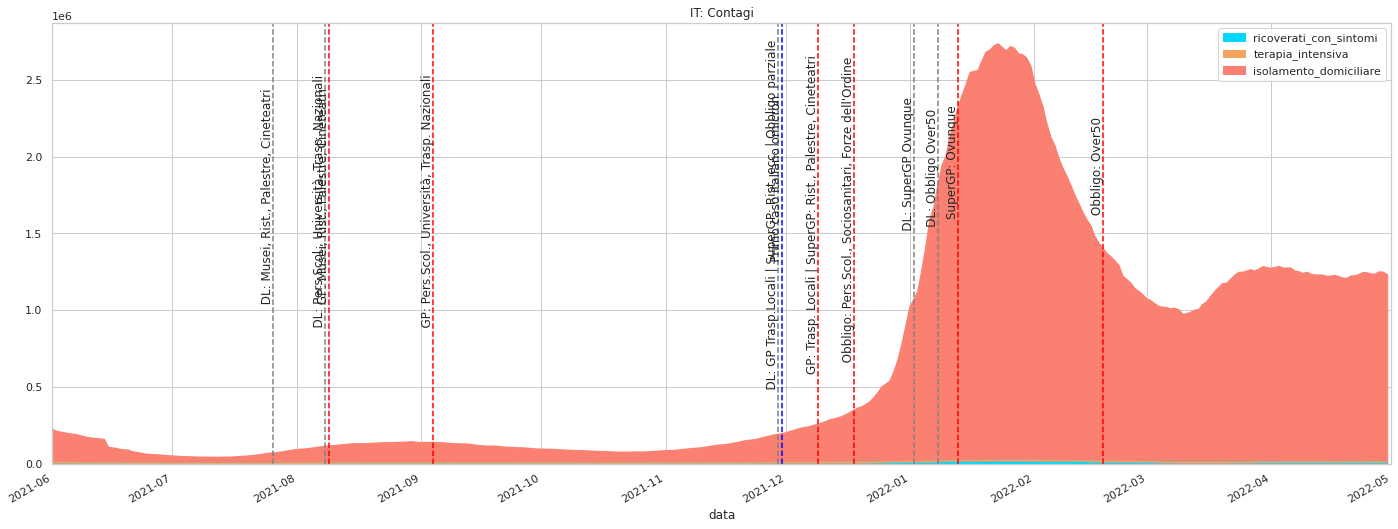

In [68]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

title = 'IT: Contagi'
ax = IT[:][['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare']].plot.area(x='data', 
                                                                                                        figsize=figsize, 
                                                                                                        stacked=True, 
                                                                                                        xlim=(start_date, end_date),
                                                                                                        title=title,
                                                                                                        color=[Color.IN_HOSPITAL, 
                                                                                                               Color.INTENSIVE_CARE,
                                                                                                               Color.QUARANTINED])
shift = td(days=3)

for d, t in dates_GP_italy:
    print_vert_line(ax, d, t, "red")
for d, t in dates_covid_italy:
    print_vert_line(ax, d, t, "blue")
for d, t in dates_laws_italy:
    print_vert_line(ax, d, t, "grey")

save_fig(ax, title)

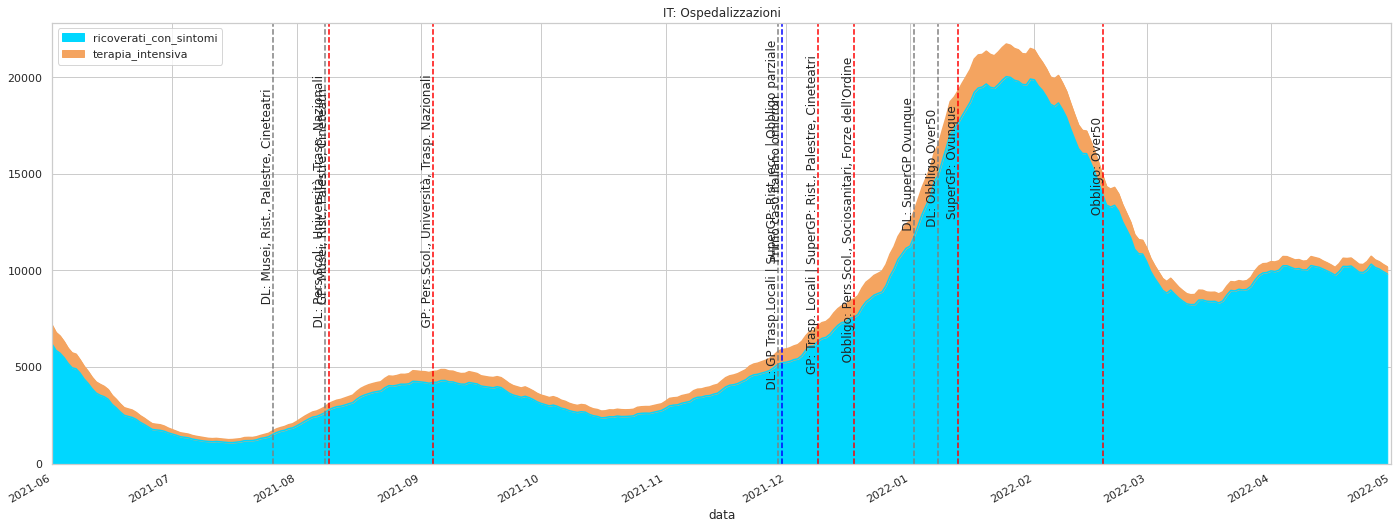

In [69]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

title = 'IT: Ospedalizzazioni'
ax = IT[:][['data', 'ricoverati_con_sintomi', 'terapia_intensiva']].plot.area(x='data', 
                                                                              figsize=figsize, 
                                                                              stacked=True, 
                                                                              xlim=(start_date, end_date),
                                                                              color=[Color.IN_HOSPITAL, Color.INTENSIVE_CARE],
                                                                              title=title)
legend_elements = [
    Patch(color=Color.IN_HOSPITAL, label='ricoverati_con_sintomi'),
    Patch(color=Color.INTENSIVE_CARE, label='terapia_intensiva')
]
ax.legend(handles=legend_elements, loc='upper left')
shift = td(days=3)

for d, t in dates_GP_italy:
    print_vert_line(ax, d, t, "red")
for d, t in dates_covid_italy:
    print_vert_line(ax, d, t, "blue")
for d, t in dates_laws_italy:
    print_vert_line(ax, d, t, "grey")

save_fig(ax, title)

Nel periodo considerato in Italia vi sono stati 37379.0 decessi, con un picco giornaliero di 469.0 decessi


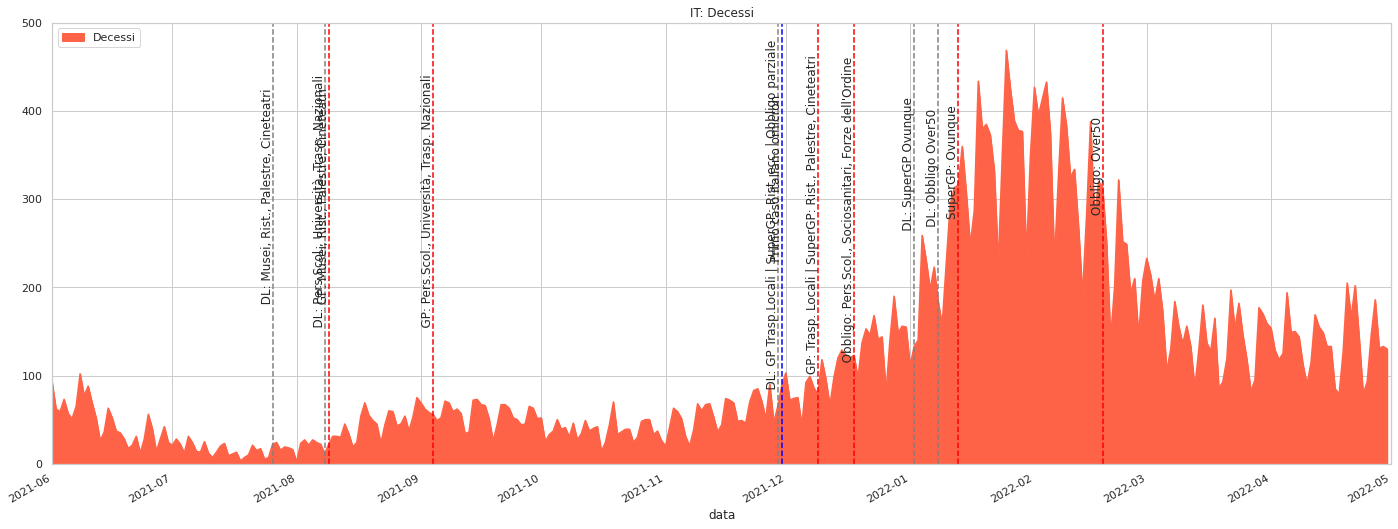

In [70]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")
title = 'IT: Decessi'
ax = IT[:][['data', 'deceduti_var']].plot.area(x='data', 
                                               figsize=figsize, 
                                               stacked=True, 
                                               xlim=(start_date, end_date),
                                               ylim=(0, 500),
                                               color=Color.DEATH,
                                               title=title)
legend_elements = [
    Patch(color=Color.DEATH, label='Decessi')
]
ax.legend(handles=legend_elements, loc='upper left')
shift = td(days=3)

for d, t in dates_GP_italy:
    print_vert_line(ax, d, t, "red")
for d, t in dates_covid_italy:
    print_vert_line(ax, d, t, "blue")
for d, t in dates_laws_italy:
    print_vert_line(ax, d, t, "grey")

save_fig(ax, title)

print(f'Nel periodo considerato in Italia vi sono stati {IT["deceduti_var"].sum()} decessi, con un picco giornaliero di {IT["deceduti_var"].max()} decessi')

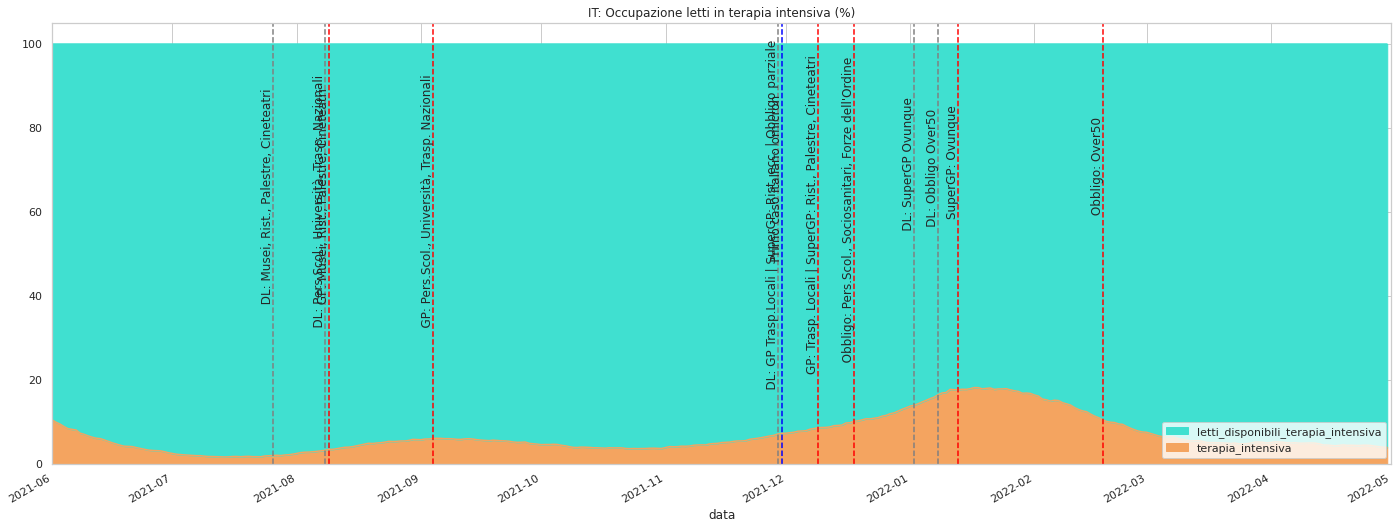

In [71]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

# 'newDeaths28DaysByDeathDate', 'newDailyNsoDeathsByDeathDate'
temp_df = IT[['data', 'letti_disponibili_terapia_intensiva', 'terapia_intensiva']].copy()
temp_df['letti_disponibili_terapia_intensiva'] = temp_df['letti_disponibili_terapia_intensiva'] / IT_ICU_beds * 100
temp_df['terapia_intensiva'] = temp_df['terapia_intensiva'] / IT_ICU_beds * 100

title = f'IT: Occupazione letti in terapia intensiva (%)'
ax = temp_df[['data', 'terapia_intensiva', 'letti_disponibili_terapia_intensiva']].plot.area(x='data', 
                                                                                             figsize=figsize, 
                                                                                             stacked=True, 
                                                                                             xlim=(start_date, end_date),
                                                                                             title=title,
                                                                                             color=[Color.INTENSIVE_CARE, Color.AVAILABLE_BEDS])
legend_elements = [
    Patch(color=Color.AVAILABLE_BEDS, label='letti_disponibili_terapia_intensiva'),
    Patch(color=Color.INTENSIVE_CARE, label='terapia_intensiva'),
]
ax.legend(handles=legend_elements, loc='lower right')
shift = td(days=3)

for d, t in dates_GP_italy:
    print_vert_line(ax, d, t, "red")
for d, t in dates_covid_italy:
    print_vert_line(ax, d, t, "blue")
for d, t in dates_laws_italy:
    print_vert_line(ax, d, t, "grey")

save_fig(ax, title)

## Vaccinations

In [72]:
IT = IT_vacc_grouped[IT_vacc_grouped['data_somministrazione'] >= start_date]

In [73]:
IT.columns

Index(['data_somministrazione', 'prima_dose', 'seconda_dose',
       'pregressa_infezione', 'dose_addizionale_booster', 'booster_immuno',
       'prima_dose_totali', 'seconda_dose_totali',
       'dose_addizionale_booster_totali', 'non_vaccinati'],
      dtype='object')

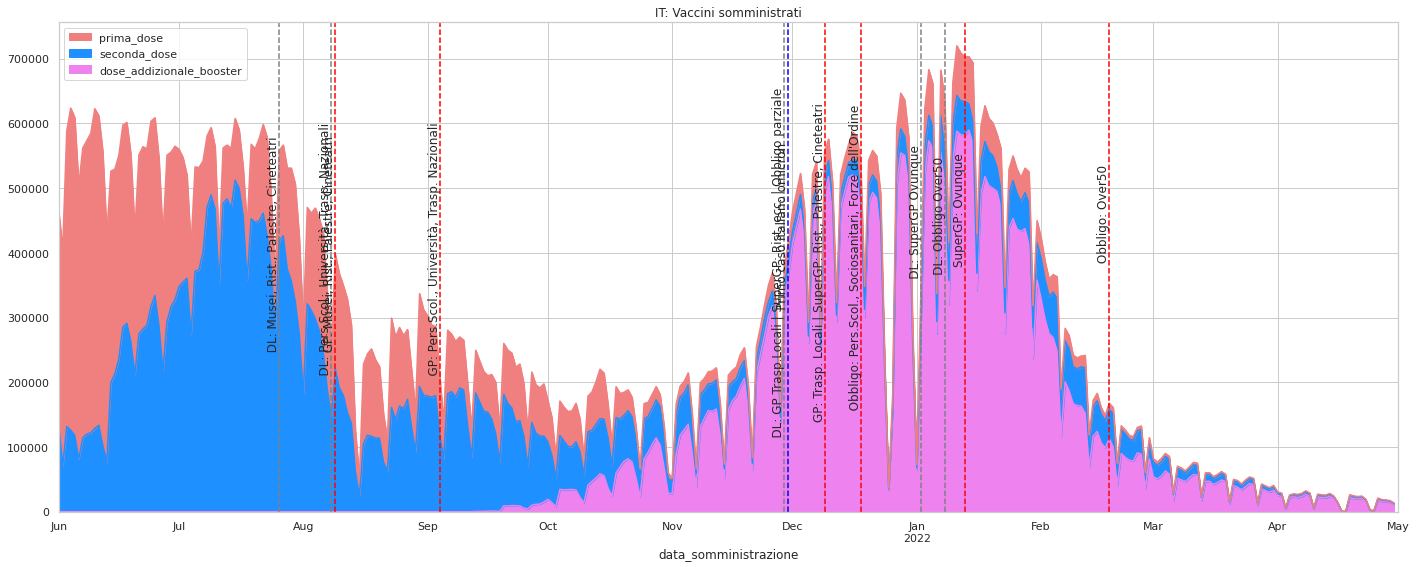

In [74]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

title = 'IT: Vaccini somministrati'
ax = IT[:][['data_somministrazione', 'dose_addizionale_booster', 'seconda_dose', 'prima_dose']].plot.area(x='data_somministrazione', 
                                                                                                          figsize=figsize, 
                                                                                                          stacked=True, 
                                                                                                          xlim=(start_date, end_date),
                                                                                                          color=[Color.THIRD_DOSE, Color.SECOND_DOSE, Color.FIRST_DOSE],
                                                                                                          title=title)
legend_elements = [
    Patch(color=Color.FIRST_DOSE, label='prima_dose'),
    Patch(color=Color.SECOND_DOSE, label='seconda_dose'),
    Patch(color=Color.THIRD_DOSE, label='dose_addizionale_booster')        
]
ax.legend(handles=legend_elements, loc='upper left')
shift = td(days=3)

for d, t in dates_GP_italy:
    print_vert_line(ax, d, t, "red")
for d, t in dates_covid_italy:
    print_vert_line(ax, d, t, "blue")
for d, t in dates_laws_italy:
    print_vert_line(ax, d, t, "grey")

save_fig(ax, title)

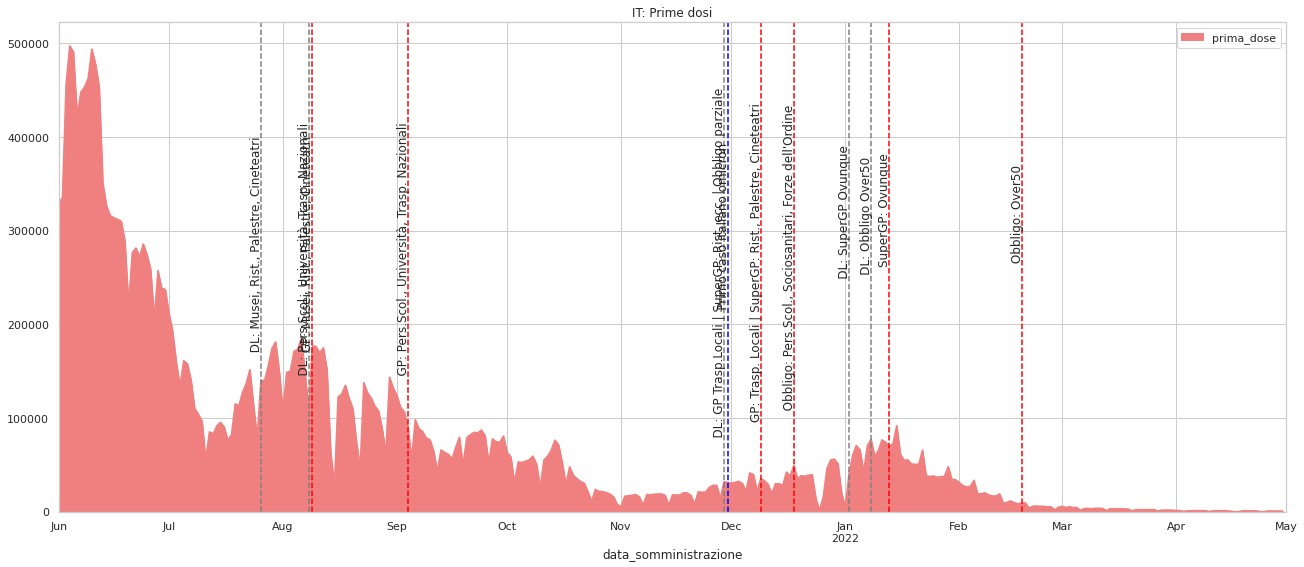

In [75]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")
title = 'IT: Prime dosi'
ax = IT[:][['data_somministrazione', 'prima_dose']].plot.area(x='data_somministrazione', 
                                                              figsize=(22, 9), 
                                                              stacked=True, 
                                                              xlim=(start_date, end_date),
                                                             title=title,
                                                             color=Color.FIRST_DOSE)
legend_elements = [
    Patch(color=Color.FIRST_DOSE, label='prima_dose')     
]
ax.legend(handles=legend_elements, loc='upper right')
shift = td(days=3)

for d, t in dates_GP_italy:
    print_vert_line(ax, d, t, "red")
for d, t in dates_covid_italy:
    print_vert_line(ax, d, t, "blue")
for d, t in dates_laws_italy:
    print_vert_line(ax, d, t, "grey")

save_fig(ax, title)

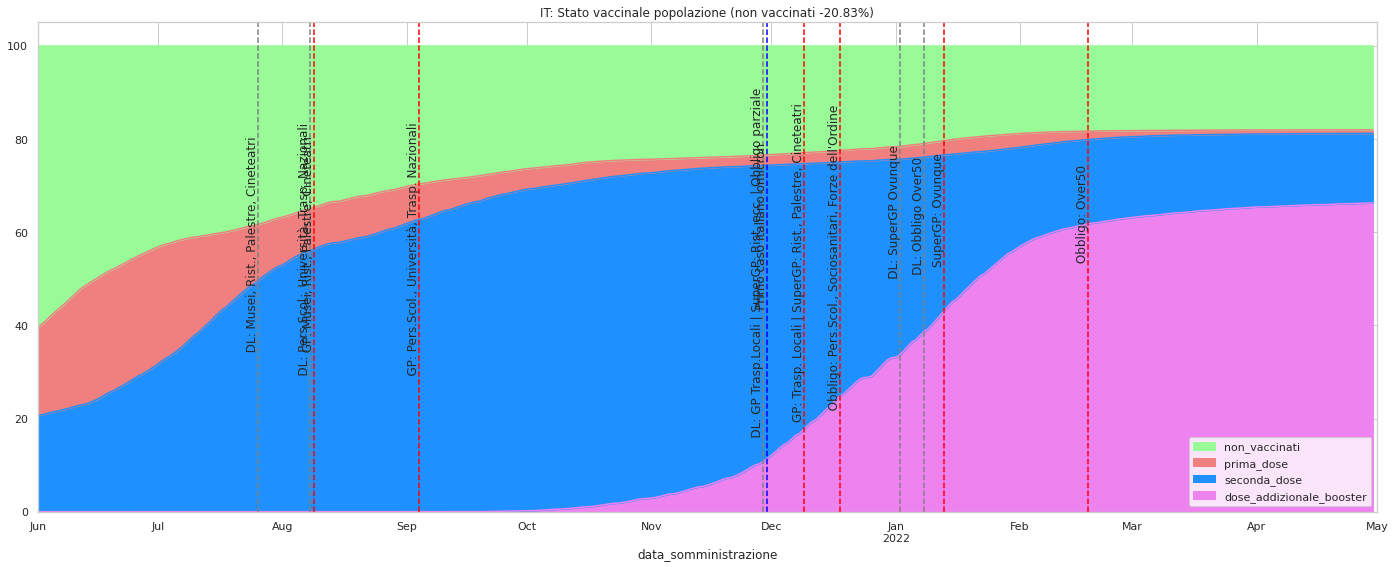

In [76]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

cols = ['dose_addizionale_booster_totali', 'seconda_dose_totali', 'prima_dose_totali', 'non_vaccinati']
temp_df = IT[:][['data_somministrazione'] + cols]
for col in cols:
    temp_df[col] /= IT_population * 10

diff_vaccinati = temp_df['non_vaccinati'].iloc[-1] - temp_df['non_vaccinati'][temp_df['data_somministrazione'] == dates_laws_italy[0][0]].iloc[0]  # Since first GP law

title = f'IT: Stato vaccinale popolazione (non vaccinati {diff_vaccinati:.02f}%)'
ax = temp_df.plot.area(x='data_somministrazione', figsize=figsize, stacked=True, xlim=(start_date, end_date), 
                       title=title,
                       color=[Color.THIRD_DOSE, Color.SECOND_DOSE, Color.FIRST_DOSE, Color.UNVACCINATED])

legend_elements = [
    Patch(color=Color.UNVACCINATED, label='non_vaccinati'),
    Patch(color=Color.FIRST_DOSE, label='prima_dose'),
    Patch(color=Color.SECOND_DOSE, label='seconda_dose'),
    Patch(color=Color.THIRD_DOSE, label='dose_addizionale_booster')        
]
ax.legend(handles=legend_elements, loc='lower right')
shift = td(days=3)

for d, t in dates_GP_italy:
    print_vert_line(ax, d, t, "red")
for d, t in dates_covid_italy:
    print_vert_line(ax, d, t, "blue")
for d, t in dates_laws_italy:
    print_vert_line(ax, d, t, "grey")
    
save_fig(ax, title)

In [77]:
IT = IT_vacc_grouped_over50[IT_vacc_grouped_over50['data_somministrazione'] >= start_date]

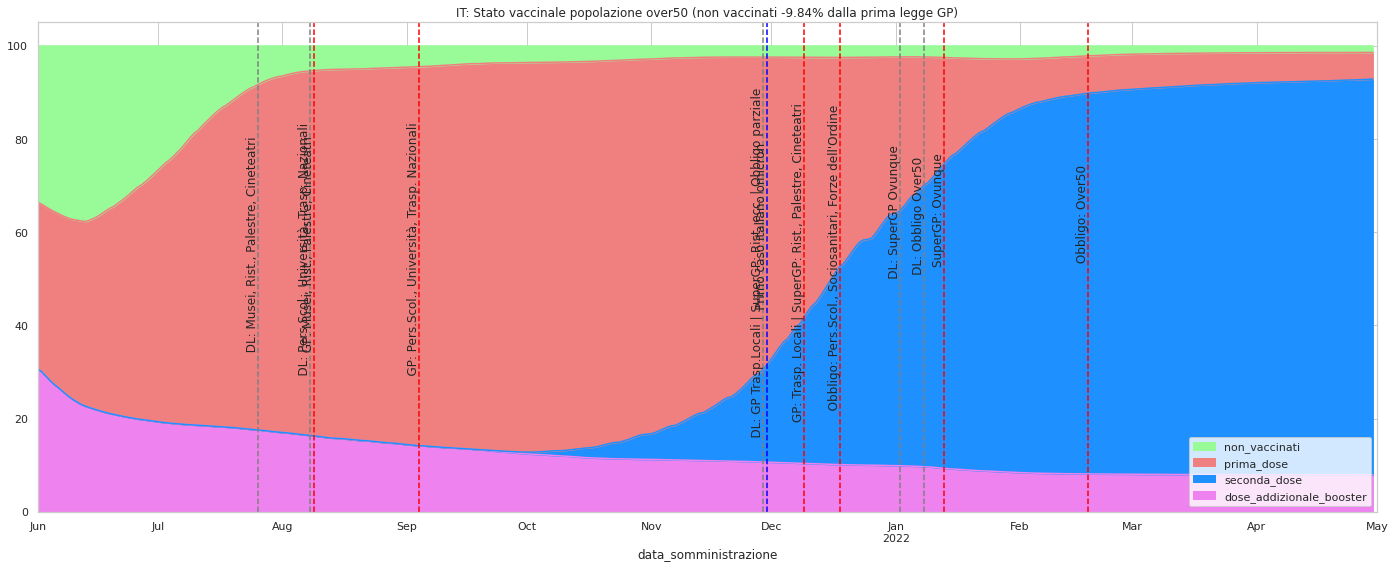

In [78]:
#set seaborn style
sns.set_theme(style="whitegrid", palette="icefire")
sns.set_theme(style="whitegrid", palette="bright")

cols = ['non_vaccinati', 'dose_addizionale_booster_totali', 'seconda_dose_totali', 'prima_dose_totali']
temp_df = IT[:][['data_somministrazione'] + cols]
for col in cols:
    temp_df[col] /= IT_population_over50 * 10

diff_vaccinati = temp_df['non_vaccinati'].iloc[-1] - temp_df['non_vaccinati'][temp_df['data_somministrazione'] == dates_laws_italy[0][0]].iloc[0]  # Since first GP law

title = f'IT: Stato vaccinale popolazione over50 (non vaccinati {diff_vaccinati:.02f}% dalla prima legge GP)'
ax = temp_df.plot.area(x='data_somministrazione', figsize=figsize, stacked=True, xlim=(start_date, end_date), 
                       title=title,
                       color=[Color.THIRD_DOSE, Color.SECOND_DOSE, Color.FIRST_DOSE, Color.UNVACCINATED])

legend_elements = [
    Patch(color=Color.UNVACCINATED, label='non_vaccinati'),
    Patch(color=Color.FIRST_DOSE, label='prima_dose'),
    Patch(color=Color.SECOND_DOSE, label='seconda_dose'),
    Patch(color=Color.THIRD_DOSE, label='dose_addizionale_booster')        
]
ax.legend(handles=legend_elements, loc='lower right')
shift = td(days=3)

for d, t in dates_GP_italy:
    print_vert_line(ax, d, t, "red")
for d, t in dates_covid_italy:
    print_vert_line(ax, d, t, "blue")
for d, t in dates_laws_italy:
    print_vert_line(ax, d, t, "grey")

save_fig(ax, title)